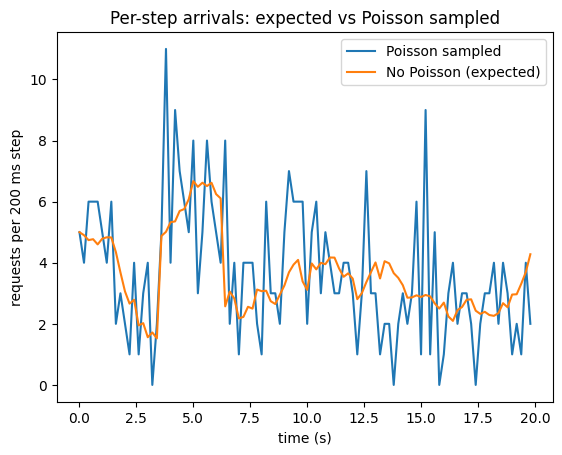

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_req_trace(
    t_steps: int,
    slot_ms: float,
    seed: int = 0,
    mu: float = 20.0,
    kappa: float = 0.05,
    sigma: float = 2.0,
    p_burst_start: float = 0.01,
    burst_mu: float = 50.0,
    burst_sigma: float = 15.0,
    burst_geom_q: float = 0.10,
    max_rate: float | None = 300.0,
):
    rng = np.random.default_rng(seed)
    dt = slot_ms / 1000.0

    x = float(mu)
    burst_remaining = 0
    current_burst_amp = 0.0

    req_per_sec = np.zeros(t_steps, dtype=float)

    for t in range(t_steps):
        # baseline OU update
        x = x + kappa * (mu - x) + sigma * rng.standard_normal()
        x = max(0.0, x)

        # burst start
        if burst_remaining <= 0 and rng.random() < p_burst_start:
            amp = max(0.0, burst_mu + burst_sigma * rng.standard_normal())
            current_burst_amp = amp

            L = 1
            while rng.random() > burst_geom_q:
                L += 1
            burst_remaining = L

        # apply burst
        burst_contrib = current_burst_amp if burst_remaining > 0 else 0.0
        if burst_remaining > 0:
            burst_remaining -= 1
        else:
            current_burst_amp = 0.0

        lam_sec = x + burst_contrib
        if max_rate is not None:
            lam_sec = min(lam_sec, float(max_rate))

        req_per_sec[t] = lam_sec

    lam_step = req_per_sec * dt
    req_poisson = rng.poisson(lam_step)
    req_no_poisson = lam_step  # deterministic

    return pd.DataFrame(
        {
            "t": np.arange(t_steps, dtype=int),
            "req_per_step_poisson": req_poisson,
            "req_per_step_no_poisson": req_no_poisson,
            "req_per_sec": req_per_sec,
        }
    )

# ----------------------------
# Compare on same plot
# ----------------------------
slot_ms = 200.0
t_steps = 100

df = generate_req_trace(
    t_steps=t_steps,
    slot_ms=slot_ms,
    seed=7,
    mu=25.0,
    kappa=0.03,
    sigma=1.8,
    p_burst_start=0.008,
    burst_mu=0.0,
    burst_sigma=20.0,
    burst_geom_q=0.08,
    max_rate=300.0,
)

time_s = df["t"] * (slot_ms / 1000.0)

plt.figure()
plt.plot(time_s, df["req_per_step_poisson"], label="Poisson sampled")
plt.plot(time_s, df["req_per_step_no_poisson"], label="No Poisson (expected)")
plt.xlabel("time (s)")
plt.ylabel(f"requests per {slot_ms:.0f} ms step")
plt.title("Per-step arrivals: expected vs Poisson sampled")
plt.legend()
plt.show()

# Allocate Detectors

In [ ]:
def allocate_detectors(
    det_costs: dict,            # {det: cycles_per_req}
    det_quality: dict | None,   # {det: score}, optional
    N: int,
    mu_cycles_per_ms: float,    # avail_cycles_aft_atk_per_ms (cycles per ms)
    D_max:int,
    gamma: float = 0.0,         # latency penalty strength (0 = hard cutoff)
):
    """
    Feasible detector mixing where feasibility is defined by a latency constraint
    computed from the current available CPU cycles.

    Latency model (per slot):
    total_cycles = sum_det n_det * c_det
    mean_latency_ms = total_cycles / mu_cycles_per_ms

    Constraint:
    mean_latency_ms <= D_Max
    Equivalent cycle budget:
    total_cycles <= D_Max * mu_cycles_per_ms

    Returns:
    plan: {det: n_req}
    feasible_all: bool
    dropped: int
    used_cycles: float
    mean_latency_ms: float
    qoe: float  (average QoE over original N, dropped contribute 0)
    """
    import math


    # no requests means no violation and full satisfaction
    if N == 0:
        return {}, True, 0, 0.0, 0.0, 1.0

    # invalid compute or latency bound means cannot serve any positive demand
    if N < 0:
        N = 0
    if mu_cycles_per_ms <= 1e-12 or D_max <= 0:
        return {}, False, int(N), 0.0, float("inf"), 0.0

    # cycle budget implied by current compute and latency bound
    C_budget = float(D_max) * float(mu_cycles_per_ms)

    # sort detectors by quality (desc), if missing then by cost (desc)
    dets = list(det_costs.keys())
    if not dets:
        return {}, False, int(N), 0.0, float("inf"), 0.0

    dets.sort(key=lambda d: float(det_quality[d]), reverse=True)
    qmax = max(1e-12, max(float(det_quality[d]) for d in dets))
    qnorm = {d: float(det_quality[d]) / qmax for d in dets}  # 0..1

    # cheapest detector as backstop
    det_light = min(dets, key=lambda d: float(det_costs[d]))
    cL = float(det_costs[det_light])

    # helper QoE from plan
    def _qoe_from_plan(plan: dict, dropped: int, used_cycles: float):
        served = int(sum(plan.values()))
        mean_latency = used_cycles / max(1e-9, mu_cycles_per_ms) if served > 0 else float("inf")

        if mean_latency >= D_max:
            lat_pen = 1.0
        else:
            lat_pen = math.exp(-gamma * (mean_latency - D_max)) if gamma > 0 else 0.0
        lat_pen = 1.0
        quality_sum = 0.0
        for det, n in plan.items():
            quality_sum += float(n) * float(qnorm.get(det, 0.0))

        qoe = (quality_sum / float(N)) * float(lat_pen) if N > 0 else 0.0
        return float(qoe), float(mean_latency)

    # if even all-light violates latency bound, serve what we can with lightest
    if N * cL > C_budget + 1e-9:
        served = int(C_budget // cL) if cL > 0 else 0
        served = max(0, min(N, served))
        plan = {det_light: served} if served > 0 else {}
        used = served * cL
        dropped = N - served
        qoe, mean_lat = _qoe_from_plan(plan, dropped, used)
        return plan, False, int(dropped), float(used), float(mean_lat), float(qoe)

    # otherwise, all N can meet latency bound, now maximize quality with feasibility backstop
    plan = {d: 0 for d in dets}
    B = float(C_budget)
    R = int(N)

    for det in dets:
        if det == det_light:
            continue
        if R <= 0:
            break

        ck = float(det_costs[det])
        if ck <= cL + 1e-12:
            continue

        # keep enough budget to run remaining requests using the lightest detector
        # n <= (B - R*cL) / (ck - cL)
        numer = B - R * cL
        denom = ck - cL
        n_max = math.floor(numer / denom + 1e-12) if denom > 0 else 0
        n = max(0, min(R, int(n_max)))

        if n > 0:
            plan[det] += n
            B -= n * ck
            R -= n

    if R > 0:
        plan[det_light] += R
        B -= R * cL
        R = 0

    used_cycles = C_budget - B
    assert sum(plan.values()) == N
    assert used_cycles <= C_budget + 1e-6

    qoe, mean_lat = _qoe_from_plan(plan, 0, used_cycles)
    return plan, True, 0, float(used_cycles), float(mean_lat), float(qoe)

def allocate_detectors_opt_dp(
    det_costs: dict,            # {det: cycles_per_req}
    det_quality: dict | None,   # {det: score}
    N: int,
    mu_cycles_per_ms: float,    # cycles per ms
    D_max: float,               # ms latency bound
    gamma: float = 0.0,
):
    """
    Optimal integer allocation via MILP (exact), falls back to greedy if PuLP not available.

    Constraints:
      sum_det n_det <= N
      sum_det n_det * c_det <= C_budget = D_max * mu_cycles_per_ms
      n_det are integers >= 0

    Objective:
      maximize (served * BIG + quality_sum_norm) so it serves as many as possible first,
      then maximizes quality among those.
    """
    import math

    if N <= 0:
        return {}, True, 0, 0.0, 0.0, 1.0
    if mu_cycles_per_ms <= 1e-12 or D_max <= 0 or not det_costs:
        return {}, False, int(N), 0.0, float("inf"), 0.0
    if det_quality is None:
        det_quality = {d: 1.0 for d in det_costs.keys()}

    dets = list(det_costs.keys())
    C_budget = float(D_max) * float(mu_cycles_per_ms)

    # normalize quality 0..1
    qmax = max(1e-12, max(float(det_quality[d]) for d in dets))
    qnorm = {d: float(det_quality[d]) / qmax for d in dets}
    c = {d: float(det_costs[d]) for d in dets}

    def _qoe_from_plan(plan: dict, used_cycles: float):
        served = int(sum(plan.values()))
        mean_latency = used_cycles / max(1e-9, mu_cycles_per_ms) if served > 0 else float("inf")
        if mean_latency <= D_max:
            lat_pen = 1.0
        else:
            lat_pen = math.exp(-gamma * (mean_latency - D_max)) if gamma > 0 else 0.0
        quality_sum = sum(float(n) * float(qnorm.get(d, 0.0)) for d, n in plan.items())
        qoe = (quality_sum / float(N)) * float(lat_pen)
        return float(qoe), float(mean_latency)

    # ---------- exact MILP (PuLP) ----------
    try:
        import pulp

        prob = pulp.LpProblem("allocate_detectors", pulp.LpMaximize)
        n_vars = {d: pulp.LpVariable(f"n_{d}", lowBound=0, upBound=N, cat=pulp.LpInteger) for d in dets}

        served = pulp.lpSum([n_vars[d] for d in dets])
        used = pulp.lpSum([c[d] * n_vars[d] for d in dets])

        prob += served <= int(N)
        prob += used <= float(C_budget)

        # serve-max then quality-max
        BIG = 10.0  # BIG should dominate quality_sum_norm/N (<=1)
        quality_sum = pulp.lpSum([qnorm[d] * n_vars[d] for d in dets])
        prob += BIG * served + quality_sum

        # solve
        prob.solve(pulp.PULP_CBC_CMD(msg=False))

        plan = {}
        for d in dets:
            v = int(round(pulp.value(n_vars[d]) or 0))
            if v > 0:
                plan[d] = v

        served_int = int(sum(plan.values()))
        used_cycles = float(sum(c[d] * n for d, n in plan.items()))
        dropped = int(N - served_int)
        feasible_all = (dropped == 0)

        qoe, mean_lat = _qoe_from_plan(plan, used_cycles)
        return plan, feasible_all, dropped, float(used_cycles), float(mean_lat), float(qoe)

    except Exception:
        pass

    # ---------- fallback: your original feasible greedy ----------
    # (kept minimal so you can drop in your own)
    dets.sort(key=lambda d: float(det_quality[d]), reverse=True)
    det_light = min(dets, key=lambda d: float(det_costs[d]))
    cL = float(det_costs[det_light])

    if N * cL > C_budget + 1e-9:
        served = int(C_budget // cL) if cL > 0 else 0
        served = max(0, min(N, served))
        plan = {det_light: served} if served > 0 else {}
        used_cycles = served * cL
        dropped = N - served
        qoe, mean_lat = _qoe_from_plan(plan, used_cycles)
        return plan, False, int(dropped), float(used_cycles), float(mean_lat), float(qoe)

    plan = {d: 0 for d in dets}
    B = float(C_budget)
    R = int(N)

    for det in dets:
        if det == det_light or R <= 0:
            continue
        ck = float(det_costs[det])
        if ck <= cL + 1e-12:
            continue
        numer = B - R * cL
        denom = ck - cL
        n_max = math.floor(numer / denom + 1e-12) if denom > 0 else 0
        n = max(0, min(R, int(n_max)))
        if n > 0:
            plan[det] += n
            B -= n * ck
            R -= n

    if R > 0:
        plan[det_light] += R
        B -= R * cL

    used_cycles = C_budget - B
    qoe, mean_lat = _qoe_from_plan({d: n for d, n in plan.items() if n > 0}, used_cycles)
    return {d: n for d, n in plan.items() if n > 0}, True, 0, float(used_cycles), float(mean_lat), float(qoe)

from service import VideoPipeline
from environment import load_globals
import yaml

cfg_path = "./configs/simulation_0.yaml"
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

globals_cfg = load_globals(cfg)

# --------------------------------------------------
# Build shared VideoPipeline
# --------------------------------------------------
video_pipeline = VideoPipeline(
    reid_latency_ms_per_object=cfg["globals"]["video_pipeline"]["reid_latency"],
    configs=cfg["globals"]["video_pipeline"]["configs"],
    cpu_cycle_per_ms=globals_cfg.cpu_cycle_per_ms,
    cpu_cores=globals_cfg.cpu_cores,
)    
import numpy as np


def test_allocate_detectors_sweep(
    allocate_detectors_fn,         # the standalone function
    det_costs: dict,               # {det: cycles_per_req}
    det_quality: dict,             # {det: score}
    num_req_list,
    cpu_list,
    cpu_cycle_per_ms: float,       # per-core cycles/ms
    D_max_ms: float,
    gamma: float = 0.0,
):
    """
    Treats `cpu` as the number of VA cores available in this slot.
    Capacity: mu_cycles_per_ms = cpu_cycle_per_ms * cpu
    Budget:   C_budget = D_max_ms * mu_cycles_per_ms
    """
    results = []
    for N in num_req_list:
        N = int(N)
        for cpu in cpu_list:
            cpu = float(8 - cpu)
            mu_cycles_per_ms = float(cpu_cycle_per_ms) * cpu

            plan, feasible_all, dropped, used_cycles, mean_lat, qoe = allocate_detectors_opt_dp(
                det_costs=det_costs,
                det_quality=det_quality,
                N=N,
                mu_cycles_per_ms=mu_cycles_per_ms,
                D_max=int(D_max_ms),
                gamma=float(gamma),
            )

            results.append(
                {
                    "N": N,
                    "cpu": cpu,
                    "mu_cycles_per_ms": mu_cycles_per_ms,
                    "feasible_all": bool(feasible_all),
                    "dropped": int(dropped),
                    "used_cycles": float(used_cycles),
                    "mean_latency_ms": float(mean_lat),
                    "qoe": float(qoe),
                    "plan": dict(plan),
                }
            )
    return results


def print_results(results):
    for r in results:
        print(
            f"N={r['N']:>4} cpu={8-r['cpu']:>4.1f} "
            f"lat={r['mean_latency_ms']:>8.2f}ms "
            f"dropped={r['dropped']:>4} qoe={r['qoe']:.4f} plan={r['plan']}"
        )


# -------- build det_costs / det_quality from your VideoPipeline --------
# IMPORTANT: det_costs must be consistent with mu_cycles_per_ms.
# If you keep VideoPipeline.det_cycles = latency_ms * cpu_cycle_per_ms * cpu_cores,
# then det_costs already includes cpu_cores and you should NOT multiply mu_cycles_per_ms by cpu_cores again.
# The safer fix is: in VideoPipeline, set cycles = latency_ms * cpu_cycle_per_ms (remove * cpu_cores).

dets = list(video_pipeline.det_cycles.keys())
det_costs = {d: float(video_pipeline.det_cycles[d]) for d in dets}
det_quality = {d: float(video_pipeline.det_quality[d]) for d in dets}

results = test_allocate_detectors_sweep(
    allocate_detectors_fn=allocate_detectors,
    det_costs=det_costs,
    det_quality=det_quality,
    # num_req_list=[10, 20, 40, 60],
    num_req_list=range(20,32,1),
    # cpu_list=[0.5, 1.5, 2.5, 4.0],
    cpu_list=[1.5],
    cpu_cycle_per_ms=globals_cfg.cpu_cycle_per_ms,  # per-core cycles/ms
    D_max_ms=200.0,
    gamma=0.0,
)

print_results(results)


N=  20 cpu= 1.5 lat=  199.90ms dropped=   0 qoe=0.8722 plan={'nanodet-plus-m_416': 9, 'nanodet-plus-m-1.5x_320': 2, 'nanodet-plus-m-1.5x_416': 9}
N=  21 cpu= 1.5 lat=  199.77ms dropped=   0 qoe=0.8492 plan={'nanodet-plus-m_416': 13, 'nanodet-plus-m-1.5x_320': 1, 'nanodet-plus-m-1.5x_416': 7}
N=  22 cpu= 1.5 lat=  199.63ms dropped=   0 qoe=0.8283 plan={'nanodet-plus-m_416': 17, 'nanodet-plus-m-1.5x_416': 5}
N=  23 cpu= 1.5 lat=  198.78ms dropped=   0 qoe=0.8068 plan={'nanodet-plus-m_416': 20, 'nanodet-plus-m-1.5x_416': 3}
N=  24 cpu= 1.5 lat=  199.73ms dropped=   0 qoe=0.7889 plan={'nanodet-plus-m_320': 1, 'nanodet-plus-m_416': 21, 'nanodet-plus-m-1.5x_416': 2}
N=  25 cpu= 1.5 lat=  199.40ms dropped=   0 qoe=0.7711 plan={'nanodet-plus-m_416': 22, 'nanodet-plus-m-1.5x_320': 3}
N=  26 cpu= 1.5 lat=  200.00ms dropped=   0 qoe=0.7513 plan={'nanodet-plus-m_320': 2, 'nanodet-plus-m_416': 18, 'nanodet-plus-m-1.5x_320': 6}
N=  27 cpu= 1.5 lat=  199.57ms dropped=   0 qoe=0.7321 plan={'nanodet-pl

In [3]:
method = "constant_1.5"
constant_cpu = float(method.split("_", 1)[1])
constant_cpu

1.5

In [1]:
# qoe_vs_request_plot_slider.py
from __future__ import annotations

import numpy as np
import plotly.graph_objects as go
from plotly.offline import plot

from environment import build_env_base


def run_qoe_vs_requests(edge, req_list, cpu_to_ids_ratio: float, attack_intensity: float, t: int = 0):
    qoes = []

    # fix CPU→IDS ratio
    edge.cpu_to_ids_ratio = float(cpu_to_ids_ratio)

    # force absolute attack intensity
    for a in edge.attackers:
        if hasattr(a, "start"):
            a.start = 0
        if hasattr(a, "df") and "flows_per_sec" in a.df.columns:
            a.df["flows_per_sec"] = float(attack_intensity)
        if hasattr(a, "_full_df") and "flows_per_sec" in a._full_df.columns:
            a._full_df["flows_per_sec"] = float(attack_intensity)

    # override user arrivals deterministically
    orig_num_requests_at = [u.num_requests_at for u in edge.users]
    try:
        for N in req_list:
            for i, u in enumerate(edge.users):
                if i == 0:
                    u.num_requests_at = (lambda _t, N=N: float(N))
                else:
                    u.num_requests_at = (lambda _t: 0.0)

            cache = edge.step_local(t)
            qoes.append(float(cache.get("qoe", 0.0)))
    finally:
        for u, fn in zip(edge.users, orig_num_requests_at):
            u.num_requests_at = fn

    return np.asarray(req_list, dtype=np.float32), np.asarray(qoes, dtype=np.float32)


def main():
    cfg_path = "./configs/simulation_0.yaml"
    env = build_env_base(cfg_path)
    env.reset()
    edge = env.edge_areas[0]

    req_list = list(range(1, 61))

    # IDS CPU allocations (cores)
    ids_allocations = [0.5, 1.5, 2.5, 4.0, 6.0]
    total_cpu = edge.budget.cpu
    cpu_to_ids_ratios = [a / total_cpu for a in ids_allocations]

    # attack intensity levels (slider values)
    attack_intensities = range(0,3000,200)

    fig = go.Figure()
    traces_per_attack = len(ids_allocations)

    # generate traces grouped by attack intensity
    for atk in attack_intensities:
        for ids_alloc, r in zip(ids_allocations, cpu_to_ids_ratios):
            x, y = run_qoe_vs_requests(
                edge=edge,
                req_list=req_list,
                cpu_to_ids_ratio=r,
                attack_intensity=atk,
                t=0,
            )
            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=y,
                    mode="lines",
                    name=f"cpu→IDS={ids_alloc:.1f}c",
                    hovertemplate="N=%{x}<br>QoE=%{y:.4f}<extra></extra>",
                    visible=False,  # enable via slider
                )
            )

    # make only first attack intensity visible initially
    for i in range(traces_per_attack):
        fig.data[i].visible = True

    # slider steps
    steps = []
    for i, atk in enumerate(attack_intensities):
        vis = [False] * len(fig.data)
        start = i * traces_per_attack
        for j in range(traces_per_attack):
            vis[start + j] = True

        steps.append(
            dict(
                method="update",
                label=f"attack={atk}",
                args=[
                    {"visible": vis},
                    {"title": f"QoE vs Requests (attack intensity = {atk})"},
                ],
            )
        )

    fig.update_layout(
        title=f"QoE vs Requests (attack intensity = {attack_intensities[0]})",
        xaxis_title="Number of requests (N)",
        yaxis_title="QoE",
        hovermode="x unified",
        sliders=[
            dict(
                active=0,
                currentvalue={"prefix": "Attack intensity: "},
                pad={"t": 50},
                steps=steps,
            )
        ],
        legend_title_text="IDS CPU allocation",
        margin=dict(l=60, r=60, t=80, b=60),
    )

    plot(fig, filename="qoe_vs_requests_slider.html", auto_open=False)


if __name__ == "__main__":
    main()